In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.signal import get_window
import glob
import time

#dBu = 20log10(V/0.775V)
#The FFT assumes that the signal is periodic and continuous within the window. 
#If the signal is not perfectly periodic, it can cause spectral leakage, which results in an offset or differences in the frequency spectrum.

def rffts(x, x_err): #the imput are 2d arrays bc this function computes multiple ffts
    window = get_window("hanning", x.shape[1])
    print(window.shape)
    print(x.shape)
    x_windowed = x * window[np.newaxis, :]
    x_err_windowed = x_err * window[np.newaxis, :]
    print(x_windowed.shape)

    N = len(x)
    print(N)
    #print(x_windowed)
    X = fft.rfft(x_windowed, axis = 1)
    X_normalized = np.abs(X) / N
    #print(X_normalized)
    X_dBu = 20*(np.log10(np.abs(X_normalized)) / 0.775)
    
    X_err = fft.rfft(x_err_windowed, axis = 1)
    X_err_normalized = np.abs(X_err) / N
    X_err_dBu = 20*(X_err_normalized) / (np.log(10) * X_normalized)
    
    return X_dBu, X_err_dBu

def mean_fft(all_magnitudes, all_errors):
    means = np.mean(all_magnitudes, axis = 0) #weights are all the same
    stat_stds = np.std(all_magnitudes, axis = 0)
    weights = 1/all_errors**2
    syst_stds = 1/weights.sum(axis = 0)
    return means, np.sqrt(stat_stds**2 + syst_stds**2)

In [2]:
hour = '12.14'
day = '290724'

# stack all wfs

In [3]:
file_pattern = f"{day}_{hour}_wf/wf_{hour}_{day}_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []

for i, file in enumerate(file_list):
    df = pd.read_csv(file)
    if i == 0:
        print(df.iloc[:, 0])
        print(df.iloc[:, 1])
        times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
    amplitudes_list.append(amplitudes)
    
#print(amplitudes_list)

all_amplitudes = np.stack(amplitudes_list, axis = 0)

ValueError: need at least one array to stack

# error on amplitudes

In [ ]:
LSB = 1/256 #1V / (2**8) = voltage range / number of levels 
error = (0.5)*LSB
amplitude_errors = np.full(all_amplitudes.shape, error)

# compute ffts of all wfs and average those

In [ ]:
X_dBu, X_err_dBu = rffts(all_amplitudes, amplitude_errors)
magnitudes, errors = mean_fft(X_dBu, X_err_dBu)

(99526,)
(64, 99526)
(64, 99526)
64


f_ s = 995.2329599185722


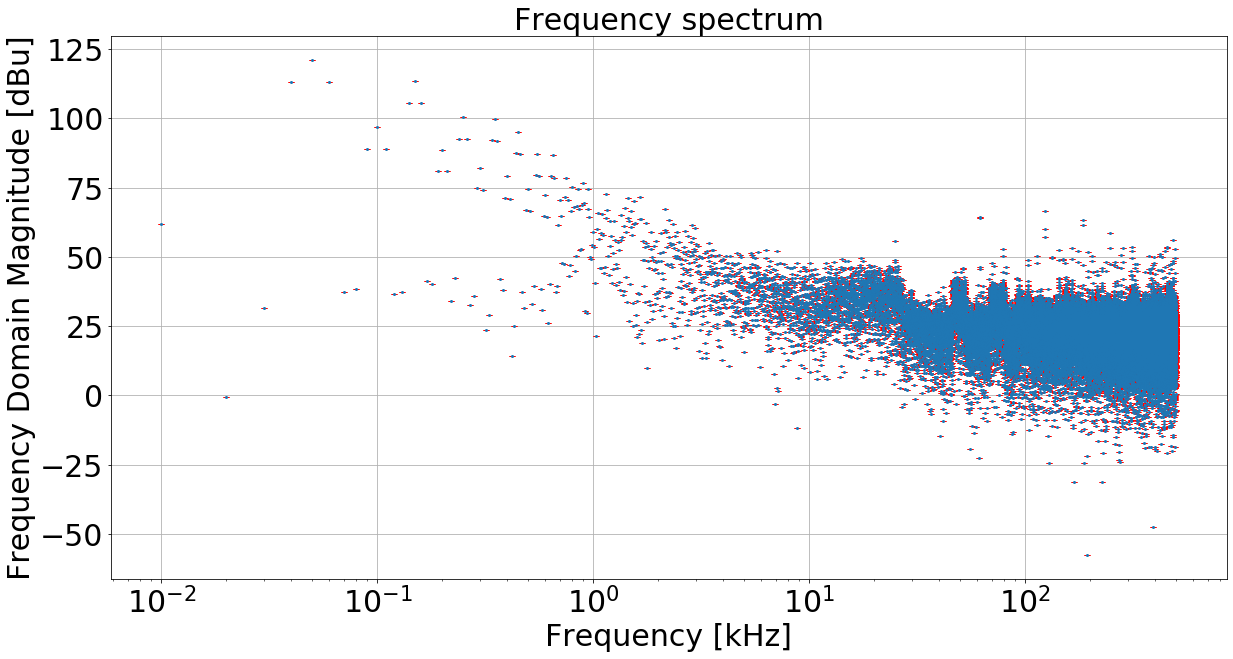

In [ ]:
span = times[len(times)-1] 
f_s = len(times) / span
print(f"f_ s = {f_s}")
freqs = fft.rfftfreq(all_amplitudes.shape[1], 1/f_s) #window lenght, sample spacing

plt.figure(figsize=(20, 10))
plt.errorbar(freqs, magnitudes, yerr = errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [kHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogx()
plt.show()

# Comparison with GUI

In [ ]:
file_pattern = f"{day}_{hour}_fft/fft_{hour}_{day}_*.csv"
file_list = glob.glob(file_pattern)

magnitudes_list = []

for i, file in enumerate(file_list):
    df = pd.read_csv(file)
    if i == 0:
        print(df.iloc[:, 0])
        print(df.iloc[:, 1])
        freqs = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        magnitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values

magnitudes_list.append(magnitudes)
    
all_magnitudes = np.stack(magnitudes_list, axis = 0)
N = all_magnitudes.shape[1]

LSB = 1/256 #1V / (2**8) = voltage range / number of levels 
error = (0.5) * LSB
magnitude_errors = np.full(all_magnitudes.shape, error)

magnitude_errors = fft.fft(magnitude_errors, axis = 1)
magnitude_errors = 20* np.abs(magnitude_errors)/(N*np.log(10)*all_magnitudes)

magnitudes, errors = mean_fft(all_magnitudes, magnitude_errors)

0               (kHz)
1          0.00000000
2          0.03037179
3          0.06074359
4          0.09111538
             ...     
16380    497.45960978
16381    497.48998158
16382    497.52035337
16383    497.55072516
16384    497.58109696
Name: Frequency, Length: 16385, dtype: object
0               (dBu)
1        -26.06713000
2        -20.72457000
3        -19.40987000
4        -27.05793000
             ...     
16380    -88.47185000
16381    -88.63280000
16382    -98.73956000
16383    -90.82276000
16384    -90.95793000
Name: Channel A, Length: 16385, dtype: object
(1, 16384)
(1, 16384)
(1, 16384)


/opt/anaconda/jupyter/envs/jupyter-base/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


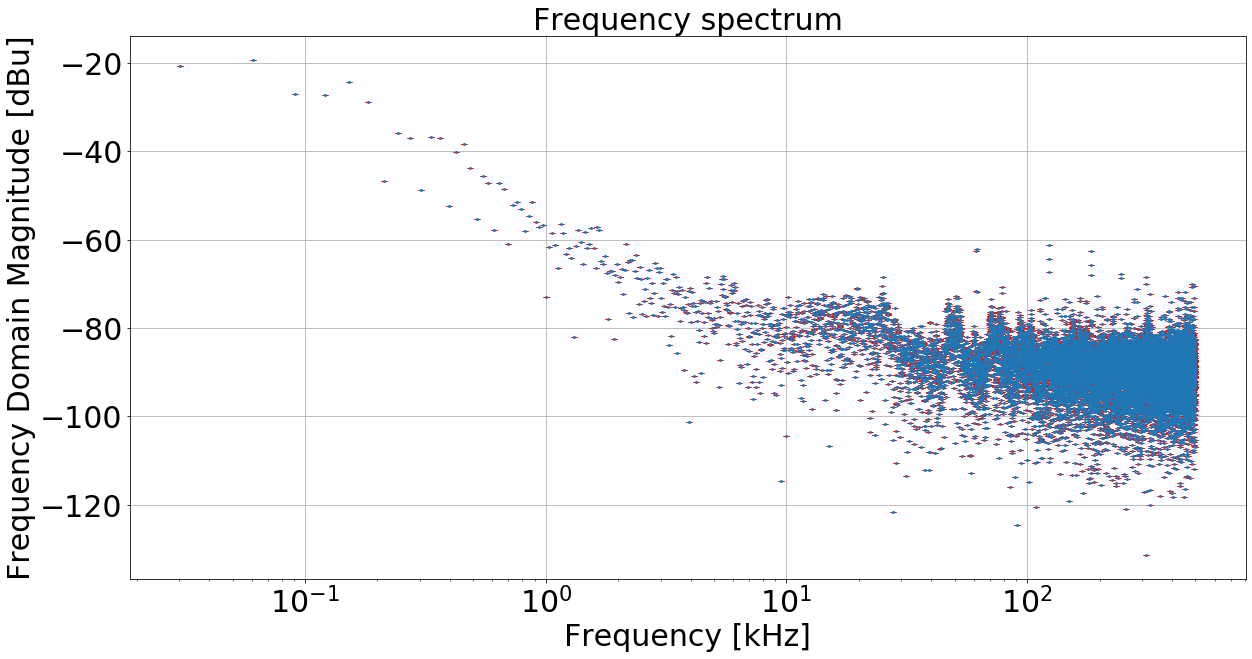

In [ ]:
plt.figure(figsize=(20, 10))
plt.errorbar(freqs, magnitudes, yerr = errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [kHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogx()
plt.show()